In [1]:
import pandas as pd
import numpy as np
import re
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('C:\\Users\\ASUS\\PycharmProjects\\RahnemaProject')

In [3]:
df = pd.read_csv('processed_df.csv')

In [4]:
list_resLen_index = df.sort_values('response_length',ascending=False).head().index
list_resTime_index = df.sort_values('response_time',ascending=False).head().index

In [5]:
df = df.drop(list(list_resLen_index))
df = df.drop(list(list_resTime_index))

In [6]:
df = df.reset_index()

In [7]:
df = df.drop('index',axis=1)
df.head()

,user_coded,ip_encoded,status_code,response_length,response_time,Head,Options,Post,Put,geo_coded,Le_coded_path,le_last_page,date_time,date_time.1
0,107,11019,304,0,32.0,0,0,0,0,110,4,62537.0,1.620780e+12,1.620780e+12
1,105,10925,200,0,24.0,1,0,0,0,110,0,62537.0,1.620780e+12,1.620780e+12
2,107,11019,304,0,16.0,0,0,0,0,110,8,4.0,1.620780e+12,1.620780e+12
3,105,38695,200,0,20.0,1,0,0,0,110,0,62537.0,1.620780e+12,1.620780e+12
4,107,11019,304,0,32.0,0,0,0,0,110,8,8.0,1.620780e+12,1.620780e+12


In [8]:
df['last_refer'] = df.groupby(['user_coded','ip_encoded'])['date_time'].shift(1)
df= df.drop('date_time.1',axis=1)

In [9]:
df.loc[df['last_refer'].isnull()==True , 'last_refer'] = 0

In [10]:
df['date_differance'] = df.apply(lambda x:x['date_time']-x['last_refer'],axis=1)

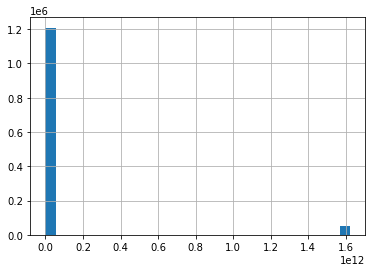

In [13]:
df['date_differance'].hist(bins=30)

In [14]:
df.head()

,user_coded,ip_encoded,status_code,response_length,response_time,Head,Options,Post,Put,geo_coded,Le_coded_path,le_last_page,date_time,last_refer,date_differance
0,107,11019,304,0,32.0,0,0,0,0,110,4,62537.0,1.620780e+12,0.000000e+00,1.620780e+12
1,105,10925,200,0,24.0,1,0,0,0,110,0,62537.0,1.620780e+12,0.000000e+00,1.620780e+12
2,107,11019,304,0,16.0,0,0,0,0,110,8,4.0,1.620780e+12,1.620780e+12,0.000000e+00
3,105,38695,200,0,20.0,1,0,0,0,110,0,62537.0,1.620780e+12,0.000000e+00,1.620780e+12
4,107,11019,304,0,32.0,0,0,0,0,110,8,8.0,1.620780e+12,1.620780e+12,0.000000e+00


---

Standardization
---

In [11]:
from sklearn.preprocessing import  StandardScaler
scalar = StandardScaler()
scalar.fit(df.drop('date_time',axis=1))
scaled = scalar.transform(df.drop('date_time',axis=1))

PCA
---

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  #to be able to visualize it
pca.fit(scaled)
DFpca = pca.transform(scaled)

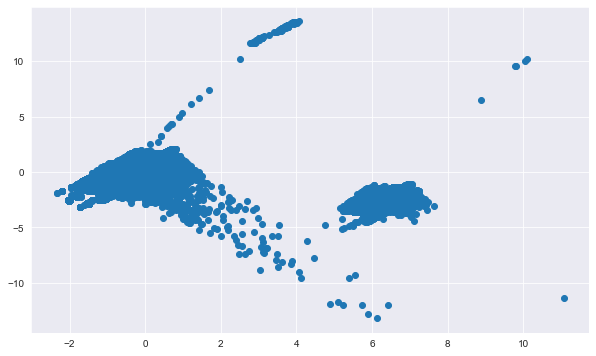

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.scatter(DFpca[:,0],DFpca[:,1])

KMEANS
---

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled)

KMeans(n_clusters=2)

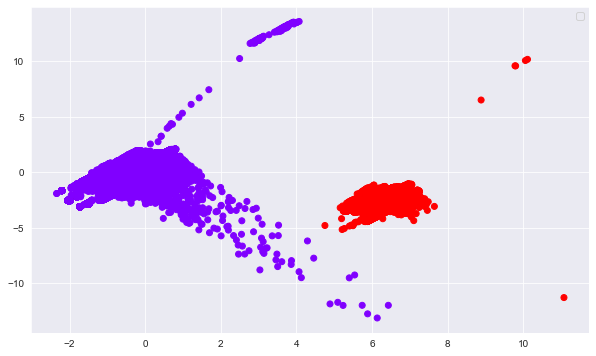

In [27]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.legend(kmeans.labels_)
plt.scatter(DFpca[:,0],DFpca[:,1],c=kmeans.labels_,cmap='rainbow')

In [29]:
df.groupby(kmeans.labels_).mean()['response_time'],df.groupby(kmeans.labels_).mean()['date_differance']

(0     6261.251954
 1    11548.317346
 Name: response_time, dtype: float64,
 0    6.813739e+04
 1    1.620801e+12
 Name: date_differance, dtype: float64)

In [71]:
df.groupby(kmeans.labels_).count()['response_time']

0    1208901
1      51124
Name: response_time, dtype: int64

In [32]:
cluster = pd.DataFrame(DFpca[:,1]>10,columns=['dim'])
cluster_index = cluster[cluster['dim']==True].index

In [24]:
import pickle
indecies = list(df[kmeans.labels_ == 1].index)

file = open('anomaly_index.txt','wb')
pickle.dump(indecies,file)

In [25]:
#file = open('anomaly_index.txt','rb')
#index = pickle.load(file)

Isolation Forest
---

In [13]:
from sklearn.ensemble import IsolationForest
Iforest= IsolationForest(n_estimators=10,contamination=0.08)

In [14]:
forest_label = Iforest.fit_predict(scaled)

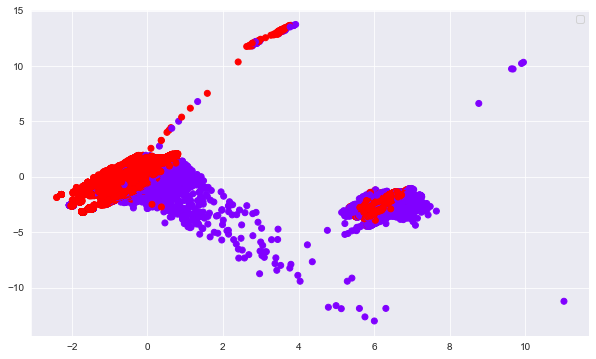

In [67]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.legend(kmeans.labels_)
plt.scatter(DFpca[:,0],DFpca[:,1],c=forest_label,cmap='rainbow')

In [ ]:
labeled = df
labeled['label'] = labeled['user_agent'].apply(lambda x:-1 if (str(x).lower().find('google')>=0 or
                                                               str(x).lower().find('python')>=0)==True else 1)

In [68]:
df.groupby(forest_label).mean()['response_time'],df.groupby(forest_label).mean()['date_differance']

(-1    95804.064533
  1     2754.371329
 Name: response_time, dtype: float64,
 -1    6.872318e+11
  1    3.987185e+10
 Name: date_differance, dtype: float64)

In [70]:
df.groupby(forest_label).count()['response_time']


-1      50393
 1    1209632
Name: response_time, dtype: int64

Elliptic Envelope
---
needs normal distribution just like z-score

In [74]:
from sklearn.covariance import EllipticEnvelope
model = EllipticEnvelope(contamination = 0.03)
ElEn_label  = model.fit_predict(df)

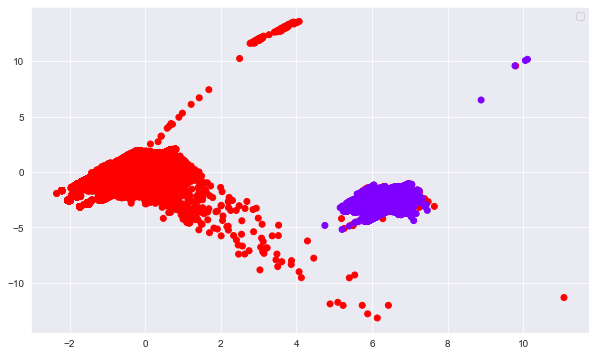

In [75]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.legend(kmeans.labels_)
plt.scatter(DFpca[:,0],DFpca[:,1],c=ElEn_label,cmap='rainbow')

In [76]:
df.groupby(ElEn_label).mean()['response_time'],df.groupby(ElEn_label).mean()['date_differance']

(-1    11430.889924
  1     6322.516048
 Name: response_time, dtype: float64,
 -1    1.620806e+12
  1    1.766766e+10
 Name: date_differance, dtype: float64)

In [77]:
df.groupby(ElEn_label).count()['response_time']


-1      37801
 1    1222224
Name: response_time, dtype: int64

Remove date features
---

In [13]:

from sklearn.preprocessing import  StandardScaler
scalar2 = StandardScaler()
scalar2.fit(df.drop(['date_time','last_refer'],axis=1))
scaled2 = scalar2.transform(df.drop(['date_time','last_refer'],axis=1))

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  #to be able to visualize it
pca.fit(scaled2)
DFpca = pca.transform(scaled2)

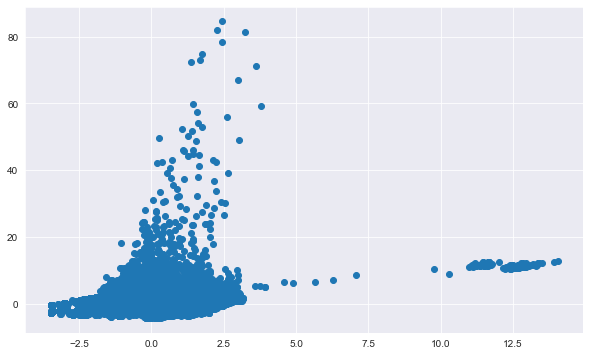

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.scatter(DFpca[:,0],DFpca[:,1])

In [16]:

from sklearn.cluster import KMeans
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(scaled2)

KMeans(n_clusters=2)

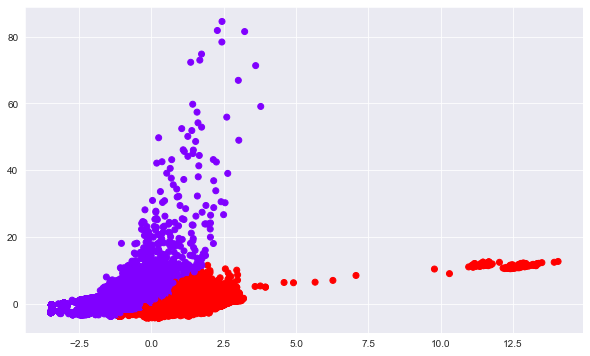

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
#plt.legend(kmeans.labels_)
plt.scatter(DFpca[:,0],DFpca[:,1],c=kmeans2.labels_,cmap='rainbow')

mini batch
---


In [17]:
from sklearn.decomposition import MiniBatchDictionaryLearning
Mdic = MiniBatchDictionaryLearning(n_components = 8,alpha = 1,batch_size = 200,n_iter = 10,
random_state = 2018)

In [18]:
Mdic.fit(scaled)
Mdic_label = Mdic.transform(scaled)

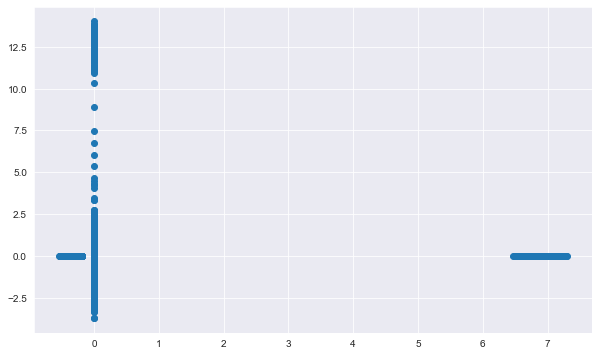

In [19]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.scatter(Mdic_label[:,0],Mdic_label[:,1])

In [20]:
df.to_csv('model_base.csv',index=False)